In [100]:
# for analysis and data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# for modelling
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ProgbarLogger
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score
import joblib
import warnings
warnings.filterwarnings("ignore")

In [92]:
def read_data(path_to_csv_file):
    '''
    Reads csv files from specified paths

    Parameters:
            path to csv file locations
    Returns:
            dataframes of imported csv files
    '''
    # Read CSV files
    df = pd.read_csv(path_to_csv_file)
    
    return df

train_df = read_data('/Users/mncedisimncwabe/Downloads/Potholes Detection/train_ids_labels.csv')
test_df = read_data('/Users/mncedisimncwabe/Downloads/Potholes Detection/test_ids_only.csv')

In [93]:
def preprocess_labels_and_ids(df):
    df['Label'] = df['Label'].astype(str)
    df['Image_ID'] = df['Image_ID'] + '.JPG'
    return df

In [94]:
def create_generators(train_df, image_dir, target_size=(32, 32), batch_size=5):
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=image_dir,
        x_col="Image_ID",
        y_col="Label",
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='training',
        shuffle=False
    )
    
    validation_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=image_dir,
        x_col="Image_ID",
        y_col="Label",
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation',
        shuffle=False
    )
    
    return train_generator, validation_generator

In [95]:
def preprocess_images(generator):
    images = []
    labels = []
    for _ in range(len(generator)):
        batch_images, batch_labels = next(generator)
        flattened_images = batch_images.reshape(batch_images.shape[0], -1)
        images.append(flattened_images)
        labels.append(batch_labels)
    return np.vstack(images), np.hstack(labels)

def standardize_data(X_train, X_val):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    return X_train, X_val

In [96]:
def train_random_forest(X_train, y_train):
    rf = RandomForestClassifier(n_estimators=150,
                                    max_depth=16,
                                    criterion='gini',
                                    class_weight='balanced',
                                    min_samples_split=10,
                                    max_leaf_nodes=20,
                                    max_features=0.5,
                                    bootstrap=True
                                    )
    rf.fit(X_train, y_train)
    return rf

def evaluate_model(log_reg, X_train, y_train, X_val, y_val):
    y_train_pred = log_reg.predict_proba(X_train)[:, 1]
    y_val_pred = log_reg.predict_proba(X_val)[:, 1]
    
    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_val, y_val_pred)
    
    train_accuracy = accuracy_score(y_train, (y_train_pred > 0.5).astype(int))
    val_accuracy = accuracy_score(y_val, (y_val_pred > 0.5).astype(int))
    
    return train_auc, val_auc, train_accuracy, val_accuracy

In [97]:
def plot_metrics(train_accuracy, val_accuracy, train_auc, val_auc):
    epochs = range(1, 3)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, [train_accuracy] * len(epochs), label='Train Accuracy')
    plt.plot(epochs, [val_accuracy] * len(epochs), label='Validation Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, [train_auc] * len(epochs), label='Train AUC')
    plt.plot(epochs, [val_auc] * len(epochs), label='Validation AUC')
    plt.title('Train and Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [98]:
def predict_on_test_data(test_df, image_dir, model, target_size=(32, 32), batch_size=5):
    # Preprocess the test_df
    test_df['Image_ID'] = test_df['Image_ID'] + '.JPG'
    
    # Create test data generator
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=image_dir,
        x_col="Image_ID",
        y_col=None,  # No labels for the test set
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        shuffle=False  # Ensure that the order is preserved
    )
    
    # Preprocess test data
    X_test = []
    for _ in range(len(test_generator)):
        batch_images = next(test_generator)
        flattened_images = batch_images.reshape(batch_images.shape[0], -1)
        X_test.append(flattened_images)
    
    X_test = np.vstack(X_test)
    
    # Standardize test data using the same scaler as training data
    scaler = StandardScaler()
    X_test = scaler.fit_transform(X_test)  # Note: Fit and transform the scaler using the test data
    
    # Predict using the trained model
    y_test_pred = model.predict_proba(X_test)[:, 1]
    
    # Create a submission DataFrame
    submission_df = pd.DataFrame({'Image_ID': test_df['Image_ID'], 'Label': y_test_pred})
    
    # Remove the '.JPG' extension from the Image_ID
    submission_df['Image_ID'] = submission_df['Image_ID'].str.replace('.JPG', '', regex=False)
    
    return submission_df

Found 3221 validated image filenames belonging to 2 classes.
Found 805 validated image filenames belonging to 2 classes.
Training AUC: 0.9886
Validation AUC: 0.9663
Training Accuracy: 0.9469
Validation Accuracy: 0.8957


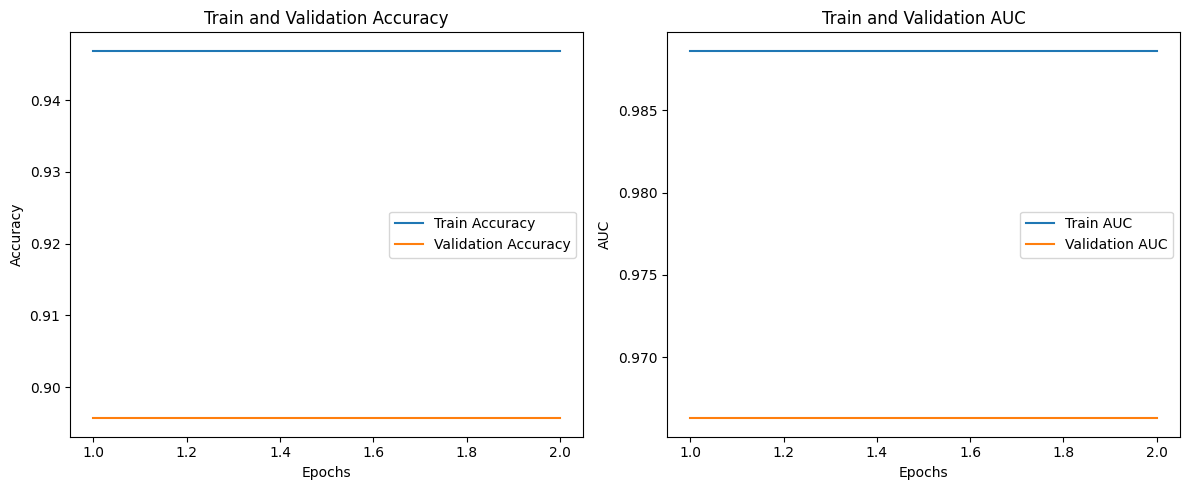

Found 1650 validated image filenames.
Submission file saved: submission.csv


In [99]:
def run_pipeline_and_predict(train_df, test_df, image_dir, output_file):
    # Preprocess labels and image IDs for training data
    train_df = preprocess_labels_and_ids(train_df)
    
    # Create data generators
    train_generator, validation_generator = create_generators(train_df, image_dir)
    
    # Preprocess training and validation data
    X_train, y_train = preprocess_images(train_generator)
    X_val, y_val = preprocess_images(validation_generator)
    
    # Standardize data
    X_train, X_val = standardize_data(X_train, X_val)
    
    # Train random forest model
    model = train_random_forest(X_train, y_train)
    
    # Evaluate the model
    train_auc, val_auc, train_accuracy, val_accuracy = evaluate_model(model, X_train, y_train, X_val, y_val)
    
    # Print results
    print(f"Training AUC: {train_auc:.4f}")
    print(f"Validation AUC: {val_auc:.4f}")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    
    # Plot metrics
    plot_metrics(train_accuracy, val_accuracy, train_auc, val_auc)
    
    # Generate predictions on the test set
    submission_df = predict_on_test_data(test_df, image_dir, model)
    
    # Save predictions to a CSV file
    submission_df.to_csv(output_file, index=False)
    print(f"Submission file saved: {output_file}")

image_dir = '/Users/mncedisimncwabe/Downloads/Potholes Detection/all_data'
output_file = 'submission.csv'
run_pipeline_and_predict(train_df, test_df, image_dir, output_file)